<a href="https://colab.research.google.com/github/hilpresent/hilpresent/blob/main/solubility_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 50.8 MB/s eta 0:00:00


In [31]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Descriptors, AllChem


import plotly.express as px
from ipywidgets import widgets, Output
from IPython.display import display, clear_output
import matplotlib.cm as cm
from google.colab import output

from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict

# Data Setup

In [6]:
!unzip csst_solubility_models.zip

Archive:  csst_solubility_models.zip
   creating: csst_solubility_models/
  inflating: csst_solubility_models/crystal16_data.pkl  
  inflating: csst_solubility_models/bootstrap_xgb_med_df.csv  
   creating: csst_solubility_models/AutogluonModels/
  inflating: csst_solubility_models/AutogluonModels/.DS_Store  
   creating: csst_solubility_models/AutogluonModels/ag-20231106_131617/
  inflating: csst_solubility_models/plateau_kfold_xgb_med_df.csv  
  inflating: csst_solubility_models/.DS_Store  
  inflating: csst_solubility_models/cc16_df.csv  
   creating: csst_solubility_models/Past/
  inflating: csst_solubility_models/Past/modeling_with_onehot_encoding.ipynb  
  inflating: csst_solubility_models/Past/solubility_models.ipynb  
  inflating: csst_solubility_models/Past/modeling_with_chemical_fingerprint.ipynb  
  inflating: csst_solubility_models/Past/multitask.ipynb  
  inflating: csst_solubility_models/Past/MT_Crystal16_Lit_Solubility_Model.ipynb  
  inflating: csst_solubility_models/Pa

In [8]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('csst_solubility_models/processed_data.csv')
print(f'df number of rows: {df.shape[0]}')
df.head()

df number of rows: 190128


,average_temperature,temperature_range,average_transmission,median_transmission,transmission_std,heating,cooling,holding,filtered,csst_reactor_id,conc,conc_unit,polymer_name,number_average_mw_min,number_average_mw_max,solvent_name,pol_smiles,sol_smiles
0,10.0,1.0,100.0,100.0,0.000000e+00,1,0,0,False,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
1,10.0,1.0,100.0,100.0,1.420000e-14,1,0,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
2,10.0,1.0,100.0,100.0,0.000000e+00,0,1,0,False,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
3,10.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
4,10.0,1.0,100.0,100.0,0.000000e+00,0,0,1,False,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]


In [9]:
tdf = df.loc[(df.holding == 1) & (df.filtered == True) & (df.transmission_std > 8) & ((df.average_temperature == 10) | (df.average_temperature == 60))]
print(f'tdf number of rows: {tdf.shape[0]}')
tdf.head()

tdf number of rows: 151


,average_temperature,temperature_range,average_transmission,median_transmission,transmission_std,heating,cooling,holding,filtered,csst_reactor_id,conc,conc_unit,polymer_name,number_average_mw_min,number_average_mw_max,solvent_name,pol_smiles,sol_smiles
887,10.0,1.0,56.135053,48.462366,19.371433,0,0,1,True,5,5.00,mg/ml,Poly methyl methacrylate,15000.0,15000.0,1-octanol,[*]CC([*])(C)C(=O)OC,CCCCCCCCO
1091,60.0,1.0,76.304402,75.247312,13.150152,0,0,1,True,5,5.00,mg/ml,Poly methyl methacrylate,15000.0,15000.0,1-octanol,[*]CC([*])(C)C(=O)OC,CCCCCCCCO
1097,10.0,1.0,69.750074,81.053763,28.471974,0,0,1,True,6,50.04,mg/ml,Poly methyl methacrylate,15000.0,15000.0,1-octanol,[*]CC([*])(C)C(=O)OC,CCCCCCCCO
1301,60.0,1.0,23.573948,19.709677,16.621751,0,0,1,True,6,50.04,mg/ml,Poly methyl methacrylate,15000.0,15000.0,1-octanol,[*]CC([*])(C)C(=O)OC,CCCCCCCCO
6985,10.0,1.0,40.201283,40.440594,11.866159,0,0,1,True,34,14.95,mg/ml,Poly methyl methacrylate,15000.0,15000.0,Heptane,[*]CC([*])(C)C(=O)OC,CCCCCCC


In [10]:
high_uncertainty_reactors = tdf.csst_reactor_id.unique()
print(f'number of high_uncertainty_reactors: {high_uncertainty_reactors.shape[0]}')
print(high_uncertainty_reactors)

number of high_uncertainty_reactors: 123
[  5   6  34  42  44  48  52  55  81  82  91 104 202 209 211 214 215 219
 222 226 230 233 236 242 246 250 258 262 263 272 278 288 305 306 307 313
 332 333 341 342 343 351 355 357 365 366 410 414 424 425 426 430 431 432
 433 470 471 472 473 482 483 484 486 490 491 504 509 510 511 512 516 533
 539 541 542 545 549 554 555 557 561 564 584 607 611 612 617 647 923 665
 667 687 726 727 733 734 736 737 753 778 788 790 804 809 811 812 819 822
 827 832 834 838 850 854 856 857 860 865 867 875 876 877 880]


In [11]:
df = df.loc[~df.csst_reactor_id.isin(high_uncertainty_reactors)]
df = df.loc[(df.transmission_std < 5) & (df.cooling == 1) & (df.filtered)].reset_index(drop=True)
print(f'df number of rows: {df.shape[0]}')
df.head()

df number of rows: 38707


,average_temperature,temperature_range,average_transmission,median_transmission,transmission_std,heating,cooling,holding,filtered,csst_reactor_id,conc,conc_unit,polymer_name,number_average_mw_min,number_average_mw_max,solvent_name,pol_smiles,sol_smiles
0,10.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
1,11.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
2,12.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
3,13.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
4,14.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]


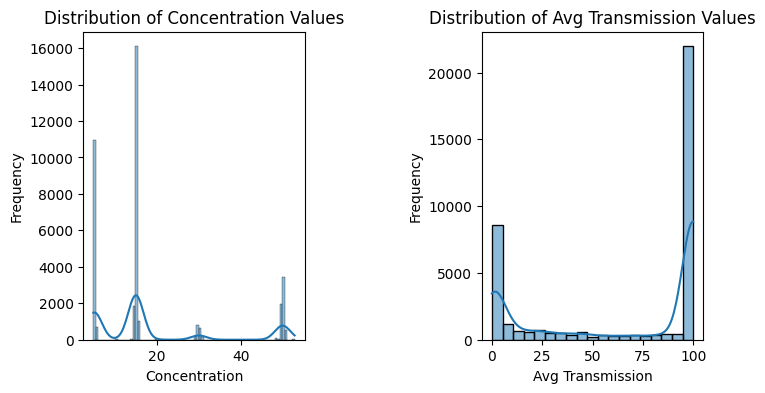

In [12]:
# hist of concentration values
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(df['conc'], kde=True, ax=axs[0])  # kde = True -> adds Kernel Density Estimate plot
axs[0].set_title('Distribution of Concentration Values')
axs[0].set_xlabel('Concentration')
axs[0].set_ylabel('Frequency')

sns.histplot(df['average_transmission'], kde=True, ax=axs[1])
axs[1].set_title('Distribution of Avg Transmission Values')
axs[1].set_xlabel('Avg Transmission')
axs[1].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0.8)
plt.show()

# Model Preprocessing

In [13]:
tdf = df[~df['polymer_name'].isin(['PEO'])]
print(tdf.shape[0])
tdf.head()

37714


,average_temperature,temperature_range,average_transmission,median_transmission,transmission_std,heating,cooling,holding,filtered,csst_reactor_id,conc,conc_unit,polymer_name,number_average_mw_min,number_average_mw_max,solvent_name,pol_smiles,sol_smiles
0,10.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
1,11.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
2,12.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
3,13.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]
4,14.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-]


In [14]:
sol_pol_pairs = tdf.groupby(['polymer_name', 'solvent_name'])
unique_pairs = list(sol_pol_pairs.groups.keys())
print(len(unique_pairs))

502


In [15]:
# rounding concentrations into the following buckets: [5, 10, 15, 20, 30, 50]
def map_conc(x):
    vals = [5, 10, 15, 20, 30, 50]
    diff = [abs(x - val) for val in vals]
    return vals[diff.index(min(diff))]

tdf['conc_round'] = tdf.apply(lambda row: map_conc(row['conc']), axis=1)

<ipython-input-15-b54eb9612fe2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['conc_round'] = tdf.apply(lambda row: map_conc(row['conc']), axis=1)


In [16]:
print(tdf.shape[0])
tdf.head()

37714


,average_temperature,temperature_range,average_transmission,median_transmission,transmission_std,heating,cooling,holding,filtered,csst_reactor_id,conc,conc_unit,polymer_name,number_average_mw_min,number_average_mw_max,solvent_name,pol_smiles,sol_smiles,conc_round
0,10.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-],5
1,11.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-],5
2,12.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-],5
3,13.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-],5
4,14.0,1.0,100.0,100.0,1.420000e-14,0,1,0,True,67,5.07,mg/ml,Poly ethylene,28.05,28.05,Nitrobenzene,[*]C[*],C1=CC=C(C=C1)[N+](=O)[O-],5


# Modeling Uncertainty with Bootstrapping

Note if tuning hyperparamters:
- if 'subsample' = 1, the entire dataset will be sampled for each iteration of the bootstrapping
- \>= 1 risks overfitting to train set

In [17]:
def extract_fp_lists(df):
    fp_pols = []
    fp_sols = []
    for col in df.columns:
        if col.startswith("fp_pol_"):
            fp_pols.append(col)
        elif col.startswith("fp_sol_"):
            fp_sols.append(col)
    return fp_pols, fp_sols

fp_pols, fp_sols = extract_fp_lists(tdf)

In [ ]:
bootstrap_xgb_med = []

n_bootstrap_samples = 10

for pair in tqdm(unique_pairs, desc="Processing pairs"):
    target_polymer, target_solvent = pair
    df_pair = tdf.loc[(tdf['polymer_name'] == target_polymer) & (tdf['solvent_name'] == target_solvent)]
    unique_concs = df_pair['conc_round'].unique()

    for conc in unique_concs:
        test_data = df_pair.loc[df_pair['conc_round'] == conc]
        train_data = tdf.loc[(tdf['polymer_name'] != target_polymer) | (tdf['solvent_name'] != target_solvent) | (tdf['conc_round'] != conc)]
        features = ['conc', 'average_temperature'] + fp_pols + fp_sols
        y_train = train_data['median_transmission']
        y_test = test_data['median_transmission'].values

        predictions = []

        for _ in range(n_bootstrap_samples):
            X_train_sample, y_train_sample = resample(train_data[features], y_train)

            model = xgb.XGBRegressor(**{'min_child_weight': 3, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 1.0, 'n_estimators': 250, 'learning_rate': 0.2})
            model.fit(X_train_sample, y_train_sample)

            pred = model.predict(test_data[features])
            predictions.append(pred)

        predictions = np.array(predictions)
        mean_predictions = np.mean(predictions, axis=0)
        uncertainty = np.std(predictions, axis=0)

        for row, actual, predicted, uncert in zip(test_data.itertuples(index=True), y_test, mean_predictions, uncertainty):
            mae = mean_absolute_error([actual], [predicted])

            bootstrap_xgb_med.append({
                'polymer': target_polymer,
                'solvent': target_solvent,
                'rounded_concentration': conc,
                'true_concentration': row.conc,
                'num_unique_concentrations': len(unique_concs),
                'avg_temperature': row.average_temperature,
                'predicted_med_transmission': predicted,
                'actual_med_transmission': actual,
                'transmission_std': row.transmission_std,
                'MAE': mae,
                'Uncertainty': uncert})

Processing pairs: 100%|█████████████████████| 502/502 [3:00:17<00:00, 21.55s/it]


In [ ]:
bootstrap_xgb_med_df = pd.DataFrame(bootstrap_xgb_med)
bootstrap_xgb_med_df.to_csv('bootstrap_xgb_med_df.csv', index=False)

In [19]:
bootstrap_xgb_med_df = pd.read_csv('csst_solubility_models/bootstrap_xgb_med_df.csv')

In [20]:
bootstrap_xgb_med_df.head()

,polymer,solvent,rounded_concentration,true_concentration,num_unique_concentrations,avg_temperature,predicted_med_transmission,actual_med_transmission,transmission_std,MAE,Uncertainty
0,Cellulose acetate,1-octanol,15,14.98,1,12.0,66.255905,48.000000,3.106563,18.255905,17.677446
1,Cellulose acetate,1-octanol,15,14.98,1,13.0,60.690758,46.800000,0.650112,13.890758,9.403318
2,Cellulose acetate,1-octanol,15,14.98,1,14.0,56.390057,45.186957,2.772321,11.203100,10.135461
3,Cellulose acetate,1-octanol,15,14.98,1,15.0,64.510700,43.756522,3.349533,20.754175,4.416452
4,Cellulose acetate,1-octanol,15,14.98,1,16.0,63.092888,45.265217,3.359587,17.827670,24.393383


In [21]:
bootstrap_mean_uncertainty = bootstrap_xgb_med_df['Uncertainty'].mean()
print(bootstrap_mean_uncertainty)

def analyze_metrics(df):
    overall_avg_metrics = df[['MAE', 'Uncertainty']].mean()
    print("Overall Average Metrics:")
    print(overall_avg_metrics)

    avg_metrics_by_conc_round = df.groupby('rounded_concentration')[['MAE', 'Uncertainty']].mean()
    print("\nAverage Metrics by Rounded Concentration:")
    print(avg_metrics_by_conc_round)

analyze_metrics(bootstrap_xgb_med_df)

9.094299211878614
Overall Average Metrics:
MAE            37.577999
Uncertainty     9.094299
dtype: float64

Average Metrics by Rounded Concentration:
                             MAE  Uncertainty
rounded_concentration                        
5                      29.716962     8.870276
10                      4.051349     1.020236
15                     40.250291     9.712347
20                     35.802912     6.975262
30                     35.665553     2.957720
50                     44.883629     9.553784


# Preprocessing for New Experiments

In [22]:
def find_plateau_temp_and_extremes(pair, consistency_threshold=5):
    pair = pair.sort_values(by='average_temperature')
    plateaus = []
    min_temp = pair['average_temperature'].min()
    max_temp = pair['average_temperature'].max()
    total_temps = len(pair['average_temperature'].unique())

    def is_plateau(subseq):
        return len(set(subseq)) == 1 and subseq.iloc[0] in [0, 100]

    i = 0
    while i < len(pair) - consistency_threshold:
        next_points = pair.iloc[i:i + consistency_threshold]['median_transmission']
        if is_plateau(next_points):
            plateau_temp = pair.iloc[i]['average_temperature']
            if not plateaus or plateaus[-1][1] != next_points.iloc[0]:
                plateaus.append((plateau_temp, next_points.iloc[0]))
            while i < len(pair) and pair.iloc[i]['median_transmission'] == next_points.iloc[0]:
                i += 1
            continue
        i += 1

    plateau_info = {'first_plateau_temp': plateaus[0][0] if plateaus else None,
                    'first_plateau_med_transmission_value': plateaus[0][1] if plateaus else None,
                    'last_plateau_temp': plateaus[-1][0] if plateaus and plateaus[0] != plateaus[-1] else None,
                    'last_plateau_med_transmission_value': plateaus[-1][1] if plateaus and plateaus[0] != plateaus[-1] else None,
                    'min_temp': min_temp,
                    'max_temp': max_temp,
                    'total_temps': total_temps}

    return plateau_info

grouped = tdf.groupby(['polymer_name', 'solvent_name', 'conc_round'])
plateau_and_extremes_list = [find_plateau_temp_and_extremes(group) for _, group in grouped]
plateau_and_extremes = pd.DataFrame(plateau_and_extremes_list)

plateau_and_extremes[['polymer_name', 'solvent_name', 'conc_round']] = pd.DataFrame(grouped.groups.keys(), columns=['polymer_name', 'solvent_name', 'conc_round'])

final_column_order = ['polymer_name', 'solvent_name', 'conc_round'] + list(plateau_and_extremes.columns.drop(['polymer_name', 'solvent_name', 'conc_round']))
plateau_and_extremes = plateau_and_extremes[final_column_order]

pd.set_option('display.max_rows', None)
print(plateau_and_extremes.shape[0])
display(plateau_and_extremes)

684


,polymer_name,solvent_name,conc_round,first_plateau_temp,first_plateau_med_transmission_value,last_plateau_temp,last_plateau_med_transmission_value,min_temp,max_temp,total_temps
0,Cellulose acetate,1-octanol,15,NaN,NaN,NaN,NaN,12.0,60.0,30
1,Cellulose acetate,Acetonitrile,15,10.0,100.0,NaN,NaN,10.0,60.0,51
2,Cellulose acetate,Anisole,15,NaN,NaN,NaN,NaN,10.0,60.0,51
3,Cellulose acetate,Benzene,15,NaN,NaN,NaN,NaN,10.0,60.0,51
4,Cellulose acetate,Benzyl alcohol,15,NaN,NaN,NaN,NaN,10.0,60.0,51
5,Cellulose acetate,Chlorobenzene,15,NaN,NaN,NaN,NaN,10.0,60.0,51
6,Cellulose acetate,Cyclopentanone,15,NaN,NaN,NaN,NaN,10.0,60.0,51
7,Cellulose acetate,DMF,15,10.0,100.0,NaN,NaN,10.0,60.0,51
8,Cellulose acetate,DMSO,15,12.0,100.0,NaN,NaN,12.0,60.0,49
9,Cellulose acetate,Diethyl ether,15,NaN,NaN,NaN,NaN,10.0,60.0,51


In [45]:
def filter_data_based_on_plateaus(pair_data, plateau_info):
    # sort data by avg temp
    pair_data = pair_data.sort_values(by='average_temperature').reset_index(drop=True)

    # intialize to be whole dataset if no plateaus
    start_idx = 0
    end_idx = len(pair_data) - 1

    # check for low and high plateaus
    if plateau_info['first_plateau_temp'] is not None and plateau_info['last_plateau_temp'] is not None:
        # two plateaus -> get the middle (+5 data points on either end)
        low_plateau_data = pair_data[pair_data['average_temperature'] == plateau_info['first_plateau_temp']]
        high_plateau_data = pair_data[pair_data['average_temperature'] == plateau_info['last_plateau_temp']]
        if not low_plateau_data.empty:
            start_idx = low_plateau_data.index[-1] + 5
        if not high_plateau_data.empty:
            end_idx = high_plateau_data.index[0] - 5
    # check just one plateau, could be at the beginning or end
    elif plateau_info['first_plateau_temp'] is not None:
        single_plateau_data = pair_data[pair_data['average_temperature'] == plateau_info['first_plateau_temp']]
        if not single_plateau_data.empty:
            if plateau_info['first_plateau_med_transmission_value'] <= 10:
                # plateau at low temps
                start_idx = single_plateau_data.index[-1] + 5
            else:
                # plateau at high temps
                end_idx = single_plateau_data.index[0] - 5

    # check bounds
    start_idx = max(start_idx, 0)
    end_idx = min(end_idx, len(pair_data) - 1)

    filtered_data = pair_data.iloc[start_idx:end_idx + 1]

    return filtered_data

filtered_pairs = []

for pair in tqdm(unique_pairs, desc='Processing pairs'):
    target_polymer, target_solvent = pair
    df_pair = tdf.loc[(tdf['polymer_name'] == target_polymer) & (tdf['solvent_name'] == target_solvent)]

    plateau_info = find_plateau_temp_and_extremes(df_pair)

    df_pair_filtered = filter_data_based_on_plateaus(df_pair, plateau_info)
    filtered_pairs.append(df_pair_filtered)

# concat the filtered DataFrames for all pairs
filtered_data = pd.concat(filtered_pairs)

Processing pairs: 100%|██████████| 502/502 [00:05<00:00, 98.06it/s] 


In [46]:
print(filtered_data.shape[0])
filtered_data.head()

35951


,average_temperature,temperature_range,average_transmission,median_transmission,transmission_std,heating,cooling,holding,filtered,csst_reactor_id,conc,conc_unit,polymer_name,number_average_mw_min,number_average_mw_max,solvent_name,pol_smiles,sol_smiles,conc_round
0,12.0,1.0,48.317054,48.000000,3.106563,0,1,0,True,606,14.98,mg/ml,Cellulose acetate,50000.0,50000.0,1-octanol,[*]OC1C(CO)OC([*])C(O)C1O,CCCCCCCCO,15
1,13.0,1.0,46.957865,46.800000,0.650112,0,1,0,True,606,14.98,mg/ml,Cellulose acetate,50000.0,50000.0,1-octanol,[*]OC1C(CO)OC([*])C(O)C1O,CCCCCCCCO,15
2,14.0,1.0,46.113686,45.186957,2.772321,0,1,0,True,606,14.98,mg/ml,Cellulose acetate,50000.0,50000.0,1-octanol,[*]OC1C(CO)OC([*])C(O)C1O,CCCCCCCCO,15
3,15.0,1.0,46.259193,43.756522,3.349533,0,1,0,True,606,14.98,mg/ml,Cellulose acetate,50000.0,50000.0,1-octanol,[*]OC1C(CO)OC([*])C(O)C1O,CCCCCCCCO,15
4,16.0,1.0,47.111144,45.265217,3.359587,0,1,0,True,606,14.98,mg/ml,Cellulose acetate,50000.0,50000.0,1-octanol,[*]OC1C(CO)OC([*])C(O)C1O,CCCCCCCCO,15


In [47]:
def extract_fp_lists(df):
    fp_pols = []
    fp_sols = []
    for col in df.columns:
        if col.startswith("fp_pol_"):
            fp_pols.append(col)
        elif col.startswith("fp_sol_"):
            fp_sols.append(col)
    return fp_pols, fp_sols

ffp_pols, ffp_sols = extract_fp_lists(filtered_data)

In [48]:
unique_pair_names = filtered_data[['polymer_name', 'solvent_name']].drop_duplicates().reset_index(drop=True)
sorted_unique_pairs = unique_pair_names.sort_values(by=['polymer_name']).reset_index(drop=True)
sorted_pair_options = [f"{row['polymer_name']} and {row['solvent_name']}" for _, row in sorted_unique_pairs.iterrows()]

def update_plot(selected_pair):
    polymer_name, solvent_name = selected_pair.split(' and ')
    pair_data = filtered_data[(filtered_data['polymer_name'] == polymer_name) & (filtered_data['solvent_name'] == solvent_name)]

    fig = px.scatter(pair_data, x='average_temperature', y='median_transmission', color='conc_round', # color based on conc_round
                     color_continuous_scale='magma', hover_data=['conc_round'],
                     title=f'Temperature vs. Transmission for {polymer_name} and {solvent_name}')
    fig.update_layout(xaxis_title='Avg Temperature', yaxis_title='Med Transmission')
    fig.show()

# dropdown
pair_dropdown = widgets.Dropdown(
    options=sorted_pair_options,
    description='Select Pair:',
    disabled=False)

widgets.interact(update_plot, selected_pair=pair_dropdown)

interactive(children=(Dropdown(description='Select Pair:', options=('Cellulose acetate and 1-octanol', 'Cellul…

<function __main__.update_plot(selected_pair)>

# Weighted Distribution K Fold Split

In [51]:
conc_counts = filtered_data['conc_round'].value_counts()
print('Concentration Counts:\n', conc_counts, '\n')

total_conc_counts = conc_counts.sum()
print('Total Concentration Counts:', total_conc_counts, '\n')

conc_to_weight = {conc: total_conc_counts/count for conc, count in conc_counts.items()}
print('Weighted Concentrations:')
display(conc_to_weight)

Concentration Counts:
 15    18308
5     10282
50     5535
30     1724
20       51
10       51
Name: conc_round, dtype: int64 

Total Concentration Counts: 35951 

Weighted Concentrations:


{15: 1.9636770810574613,
 5: 3.496498735654542,
 50: 6.495212285456188,
 30: 20.853248259860788,
 20: 704.9215686274509,
 10: 704.9215686274509}

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

additional_features = ['heating', 'cooling', 'holding']
features = ['conc', 'average_temperature'] + ffp_pols + ffp_sols + additional_features

weighted_kfold_xgb_med = []

for pair in tqdm(unique_pairs, desc="Processing pairs"):
    target_polymer, target_solvent = pair
    df_pair = filtered_data.loc[(filtered_data['polymer_name'] == target_polymer) & (filtered_data['solvent_name'] == target_solvent)]
    unique_concs = df_pair['conc_round'].unique()

    for conc in unique_concs:
        test_data_conc = df_pair.loc[df_pair['conc_round'] == conc]
        train_data = filtered_data.loc[(filtered_data['polymer_name'] != target_polymer) | (filtered_data['solvent_name'] != target_solvent) | (filtered_data['conc_round'] != conc)]

        X_train = train_data[features].values
        y_train = train_data['median_transmission'].values
        sample_weights = train_data['conc_round'].apply(lambda x: conc_to_weight[x]).values

        all_predictions = []
        all_actuals = []

        for train_index, test_index in kf.split(X_train):
            model = xgb.XGBRegressor(**{'min_child_weight': 3, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 1.0, 'n_estimators': 250, 'learning_rate': 0.2})
            model.fit(X_train[train_index], y_train[train_index], sample_weight=sample_weights[train_index])

            pred = model.predict(X_train[test_index])
            all_predictions.extend(pred)
            all_actuals.extend(y_train[test_index])

        all_predictions = np.array(all_predictions)
        all_actuals = np.array(all_actuals)
        mae = mean_absolute_error(all_actuals, all_predictions)
        uncertainty = np.std(all_predictions)

        for i in range(len(all_predictions)):
            weighted_kfold_xgb_med.append({'polymer': target_polymer,
                                               'solvent': target_solvent,
                                               'rounded_concentration': conc,
                                               'true_concentration': test_data_conc['conc'].iloc[0],
                                               'num_unique_concentrations': len(unique_concs),
                                               'avg_temperature': test_data_conc['average_temperature'].iloc[0],
                                               'predicted_med_transmission': all_predictions[i],
                                               'actual_med_transmission': all_actuals[i],
                                               'transmission_std': test_data_conc['transmission_std'].iloc[0],
                                               'MAE': mae,
                                               'Uncertainty': uncertainty})

Processing pairs:   6%|▌         | 28/502 [09:13<2:14:14, 16.99s/it]

In [ ]:
weighted_kfold_xgb_med_df = pd.DataFrame(weighted_kfold_xgb_med)
weighted_kfold_xgb_med_df.to_csv('weighted_kfold_xgb_med_df.csv', index=False)

In [50]:
# weighted_kfold_xgb_med_df = pd.read_csv('csst_solubility_models/weighted_kfold_xgb_med_df.csv')

In [ ]:
weighted_kfold_xgb_med_df.head()

In [ ]:
weighted_kfold_mean_uncertainty = weighted_kfold_xgb_med_df['Uncertainty'].mean()
print(weighted_kfold_mean_uncertainty)

analyze_metrics(weighted_kfold_xgb_med_df)

# K Fold Split

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

additional_features = ['heating', 'cooling', 'holding']
features = ['conc', 'average_temperature'] + ffp_pols + ffp_sols + additional_features

kfold_xgb_med = []

for pair in tqdm(unique_pairs, desc="Processing pairs"):
    target_polymer, target_solvent = pair
    df_pair = filtered_data.loc[(filtered_data['polymer_name'] == target_polymer) & (filtered_data['solvent_name'] == target_solvent)]
    unique_concs = df_pair['conc_round'].unique()

    for conc in unique_concs:
        test_data_conc = df_pair.loc[df_pair['conc_round'] == conc]
        train_data = filtered_data.loc[(filtered_data['polymer_name'] != target_polymer) | (filtered_data['solvent_name'] != target_solvent) | (filtered_data['conc_round'] != conc)]

        X_train = train_data[features].values
        y_train = train_data['median_transmission'].values

        all_predictions = []
        all_actuals = []

        for train_index, test_index in kf.split(X_train):
            model = xgb.XGBRegressor(**{'min_child_weight': 3, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 1.0, 'n_estimators': 250, 'learning_rate': 0.2})
            model.fit(X_train[train_index], y_train[train_index])  # no sample_weights param

            pred = model.predict(X_train[test_index])
            all_predictions.extend(pred)
            all_actuals.extend(y_train[test_index])

        all_predictions = np.array(all_predictions)
        all_actuals = np.array(all_actuals)
        mae = mean_absolute_error(all_actuals, all_predictions)
        uncertainty = np.std(all_predictions)

        for i in range(len(all_predictions)):
            kfold_xgb_med.append({'polymer': target_polymer,
                                               'solvent': target_solvent,
                                               'rounded_concentration': conc,
                                               'true_concentration': test_data_conc['conc'].iloc[0],
                                               'num_unique_concentrations': len(unique_concs),
                                               'avg_temperature': test_data_conc['average_temperature'].iloc[0],
                                               'predicted_med_transmission': all_predictions[i],
                                               'actual_med_transmission': all_actuals[i],
                                               'transmission_std': test_data_conc['transmission_std'].iloc[0],
                                               'MAE': mae,
                                               'Uncertainty': uncertainty})

In [ ]:
kfold_xgb_med_df = pd.DataFrame(kfold_xgb_med)
kfold_xgb_med_df.to_csv('kfold_xgb_med_df.csv', index=False)

In [40]:
# kfold_xgb_med_df = pd.read_csv('csst_solubility_models/kfold_xgb_med_df.csv')

,polymer,solvent,rounded_concentration,true_concentration,num_unique_concentrations,avg_temperature,predicted_med_transmission,actual_med_transmission,transmission_std,MAE,Uncertainty
0,Cellulose acetate,1-octanol,15,14.98,1,12.0,64.718980,100.0,3.106563,29.729714,28.508633
1,Cellulose acetate,1-octanol,15,14.98,1,12.0,62.790493,100.0,3.106563,29.729714,28.508633
2,Cellulose acetate,1-octanol,15,14.98,1,12.0,67.283180,100.0,3.106563,29.729714,28.508633
3,Cellulose acetate,1-octanol,15,14.98,1,12.0,64.383200,100.0,3.106563,29.729714,28.508633
4,Cellulose acetate,1-octanol,15,14.98,1,12.0,71.215400,100.0,3.106563,29.729714,28.508633


In [ ]:
kfold_xgb_med_df.head()

In [ ]:
kfold_mean_uncertainty = kfold_xgb_med_df['Uncertainty'].mean()
print(kfold_mean_uncertainty)

analyze_metrics(kfold_xgb_med_df)

Notes:
- dfferent transmissions at different temps
- differet at clear at cloud points -> heating up/cooling down

- multitask -> ramping or cooling vs transmission?

- stick with weighted average
    - weighted w current dataset (no middle values)
    - throw out all high standard deviation
- middle values

- create dataset with just filtered plateau data
- plot transmissions in a histogram
- for training -> instead of leave 1 out, this time do a group k split 5 fold split
    - do hyperparameter tuning, take best model, and plot like in paper (bar plot)
    - compare performance with the dataset where we're not witholding plateau
    - once we have best parameters, do group k fold split on full dataset AND withhold the non-plateau data
    - for test dataset, predict on all (don't withold plateau data) AND then take that k fold (mean +/- stdev)

### Create Dataframe with Only Filtered Plateau Data

In [42]:
# def filter_plateau_data(pair_data, plateau_info):
#     plateau_data = pd.DataFrame()
#     if plateau_info['first_plateau_temp'] is not None:
#         # include data from the first plateau
#         plateau_data = pd.concat([plateau_data, pair_data[pair_data['average_temperature'] == plateau_info['first_plateau_temp']]])
#     if plateau_info['last_plateau_temp'] is not None and plateau_info['last_plateau_temp'] != plateau_info['first_plateau_temp']:
#         # second plateau (if applicable)
#         plateau_data = pd.concat([plateau_data, pair_data[pair_data['average_temperature'] == plateau_info['last_plateau_temp']]])
#     return plateau_data

# # filter for the plateau data for each unique pair
# filtered_plateau_pairs = []

# for pair in tqdm(unique_pairs, desc="Processing pairs"):
#     target_polymer, target_solvent = pair
#     df_pair = tdf.loc[(tdf['polymer_name'] == target_polymer) & (tdf['solvent_name'] == target_solvent)]

#     plateau_info = find_plateau_temp_and_extremes(df_pair)

#     df_pair_plateau = filter_plateau_data(df_pair, plateau_info)
#     filtered_plateau_pairs.append(df_pair_plateau)

# # concatenate the filtered plateau DataFrames for all pairs
# filtered_plateau_data = pd.concat(filtered_plateau_pairs)

# # reorder the columns to start with 'polymer_name' and 'solvent_name'
# proper_order = ['polymer_name', 'solvent_name'] + [col for col in filtered_plateau_data.columns if col not in ['polymer_name', 'solvent_name']]
# filtered_plateau_data = filtered_plateau_data[proper_order]

# # reset index
# filtered_plateau_data.reset_index(drop=True, inplace=True)

Processing pairs: 100%|██████████| 502/502 [00:05<00:00, 97.74it/s]


In [43]:
# filtered_plateau_data.head(10)

,polymer_name,solvent_name,average_temperature,temperature_range,average_transmission,median_transmission,transmission_std,heating,cooling,holding,filtered,csst_reactor_id,conc,conc_unit,number_average_mw_min,number_average_mw_max,pol_smiles,sol_smiles,conc_round
0,Cellulose acetate,Acetonitrile,10.0,1.0,100.0,100.0,0.0,0,1,0,True,601,14.96,mg/ml,50000.0,50000.0,[*]OC1C(CO)OC([*])C(O)C1O,CC#N,15
1,Cellulose acetate,DMF,10.0,1.0,100.0,100.0,0.0,0,1,0,True,599,15.14,mg/ml,50000.0,50000.0,[*]OC1C(CO)OC([*])C(O)C1O,CN(C)C=O,15
2,Cellulose acetate,DMSO,12.0,1.0,100.0,100.0,0.0,0,1,0,True,598,14.92,mg/ml,50000.0,50000.0,[*]OC1C(CO)OC([*])C(O)C1O,CS(=O)C,15
3,Cellulose acetate,Pyridine,10.0,1.0,100.0,100.0,0.0,0,1,0,True,600,15.36,mg/ml,50000.0,50000.0,[*]OC1C(CO)OC([*])C(O)C1O,C1=CC=NC=C1,15
4,Dextran,DMSO,10.0,1.0,0.0,0.0,0.0,0,1,0,True,227,4.96,mg/ml,9000.0,10000.0,[*]COC1OC([*])C(O)C(O)C1O,CS(=O)C,5
5,Dextran,DMSO,10.0,1.0,0.0,0.0,0.0,0,1,0,True,228,50.03,mg/ml,9000.0,10000.0,[*]COC1OC([*])C(O)C(O)C1O,CS(=O)C,50
6,Dextran,Diethyl ether,10.0,1.0,0.0,0.0,0.0,0,1,0,True,252,15.03,mg/ml,9000.0,10000.0,[*]COC1OC([*])C(O)C(O)C1O,CCOCC,15
7,Dextran,Ethyl Acetate,10.0,1.0,0.0,0.0,0.0,0,1,0,True,240,14.54,mg/ml,9000.0,10000.0,[*]COC1OC([*])C(O)C(O)C1O,CCOC(=O)C,15
8,Dextran,Formamide,10.0,1.0,100.0,100.0,0.0,0,1,0,True,259,15.02,mg/ml,9000.0,10000.0,[*]COC1OC([*])C(O)C(O)C1O,C(=O)N,15
9,Dextran,NMP,10.0,1.0,100.0,100.0,0.0,0,1,0,True,229,5.00,mg/ml,9000.0,10000.0,[*]COC1OC([*])C(O)C(O)C1O,CN1CCCC1=O,5


In [ ]:
tdf_length = len(tdf)
print(f'Length of original DataFrame: {tdf_length}')

filtered_data_length = len(filtered_data)
print(f'Length of filtered data DataFrame: {filtered_data_length}')

filtered_plateau_data_length = len(filtered_plateau_data)
print(f'Length of filtered plateau DataFrame: {filtered_plateau_data_length}')

Length of original DataFrame: 37714
Length of filtered data DataFrame: 37512
Length of filtered plateau DataFrame: 176


In [ ]:
# new code, curious how it changes
tdf_length = len(tdf)
print(f'Length of original DataFrame: {tdf_length}')

filtered_data_length = len(filtered_data)
print(f'Length of filtered data DataFrame: {filtered_data_length}')

# filtered_plateau_data_length = len(filtered_plateau_data)
# print(f'Length of filtered plateau DataFrame: {filtered_plateau_data_length}')

### Plot TDF Transmissions in a Histogram

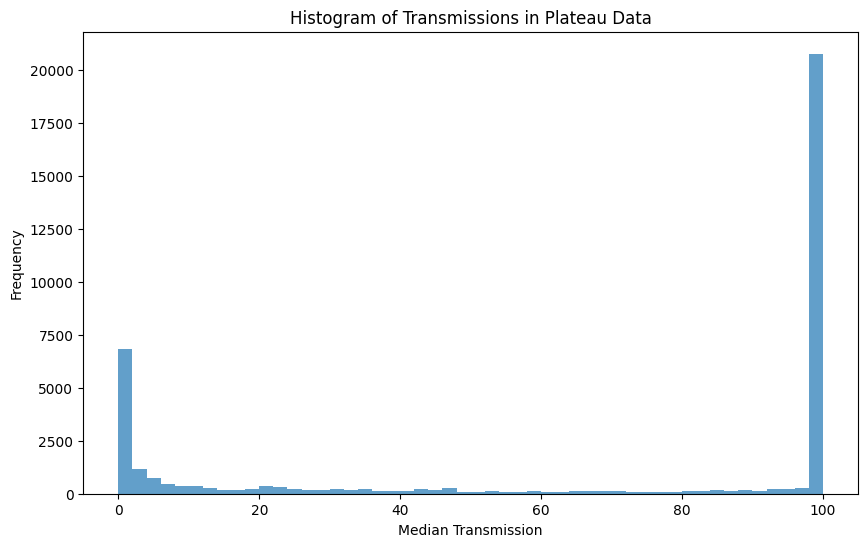

In [ ]:
# plt hist of the transmissions
plt.figure(figsize=(10, 6))
plt.hist(tdf['median_transmission'], bins=50, alpha=0.7)
plt.xlabel('Median Transmission')
plt.ylabel('Frequency')
plt.title('Histogram of Transmissions in Plateau Data')
plt.show()

### Plot Filtered Data Transmissions in a Histogram

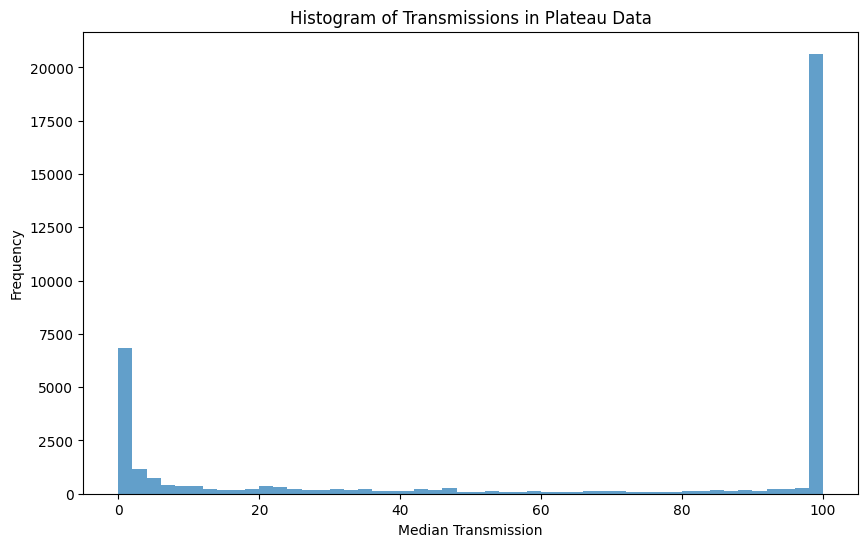

In [ ]:
# plt hist of the transmissions
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['median_transmission'], bins=50, alpha=0.7)
plt.xlabel('Median Transmission')
plt.ylabel('Frequency')
plt.title('Histogram of Transmissions in Plateau Data')
plt.show()

### Plot Filtered Plateau Data Transmissions in a Histogram

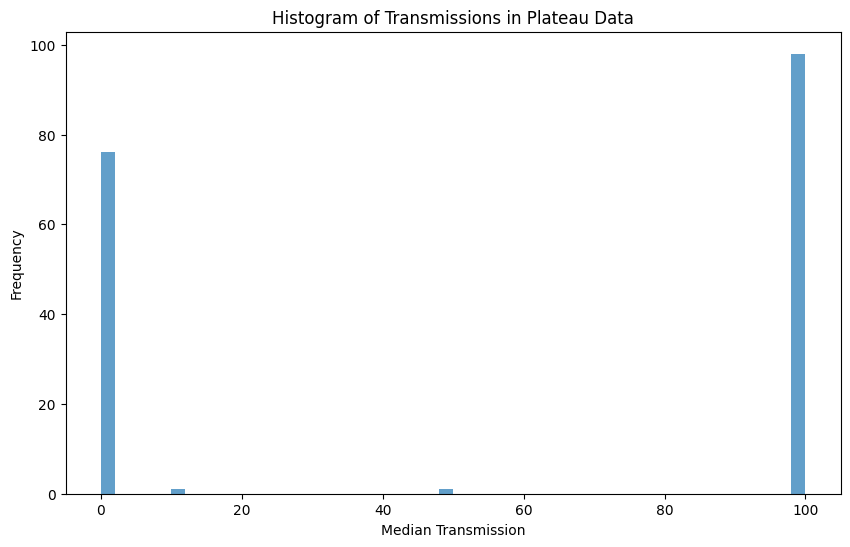

In [ ]:
# # plt hist of the transmissions
# plt.figure(figsize=(10, 6))
# plt.hist(filtered_plateau_data['median_transmission'], bins=50, alpha=0.7)
# plt.xlabel('Median Transmission')
# plt.ylabel('Frequency')
# plt.title('Histogram of Transmissions in Plateau Data')
# plt.show()

### Group K-Fold Split 5-Fold Split for Training with Hyperparameter Tuning

In [ ]:
# define the model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor())])

# define param grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

# ensure only using numeric features for fitting the model
numeric_features = filtered_data.select_dtypes(include=[np.number]).columns.tolist()
features = filtered_data[numeric_features]

# GroupKFold split
group_kfold = GroupKFold(n_splits=5)
groups = filtered_data['polymer_name'].astype(str) + "_" + filtered_data['solvent_name'].astype(str)

# grid search w cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=group_kfold, scoring='r2', n_jobs=-1)
grid_search.fit(features, filtered_data['median_transmission'], groups=groups)

# get the best model
best_model = grid_search.best_estimator_

In [ ]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

# best depth around 7

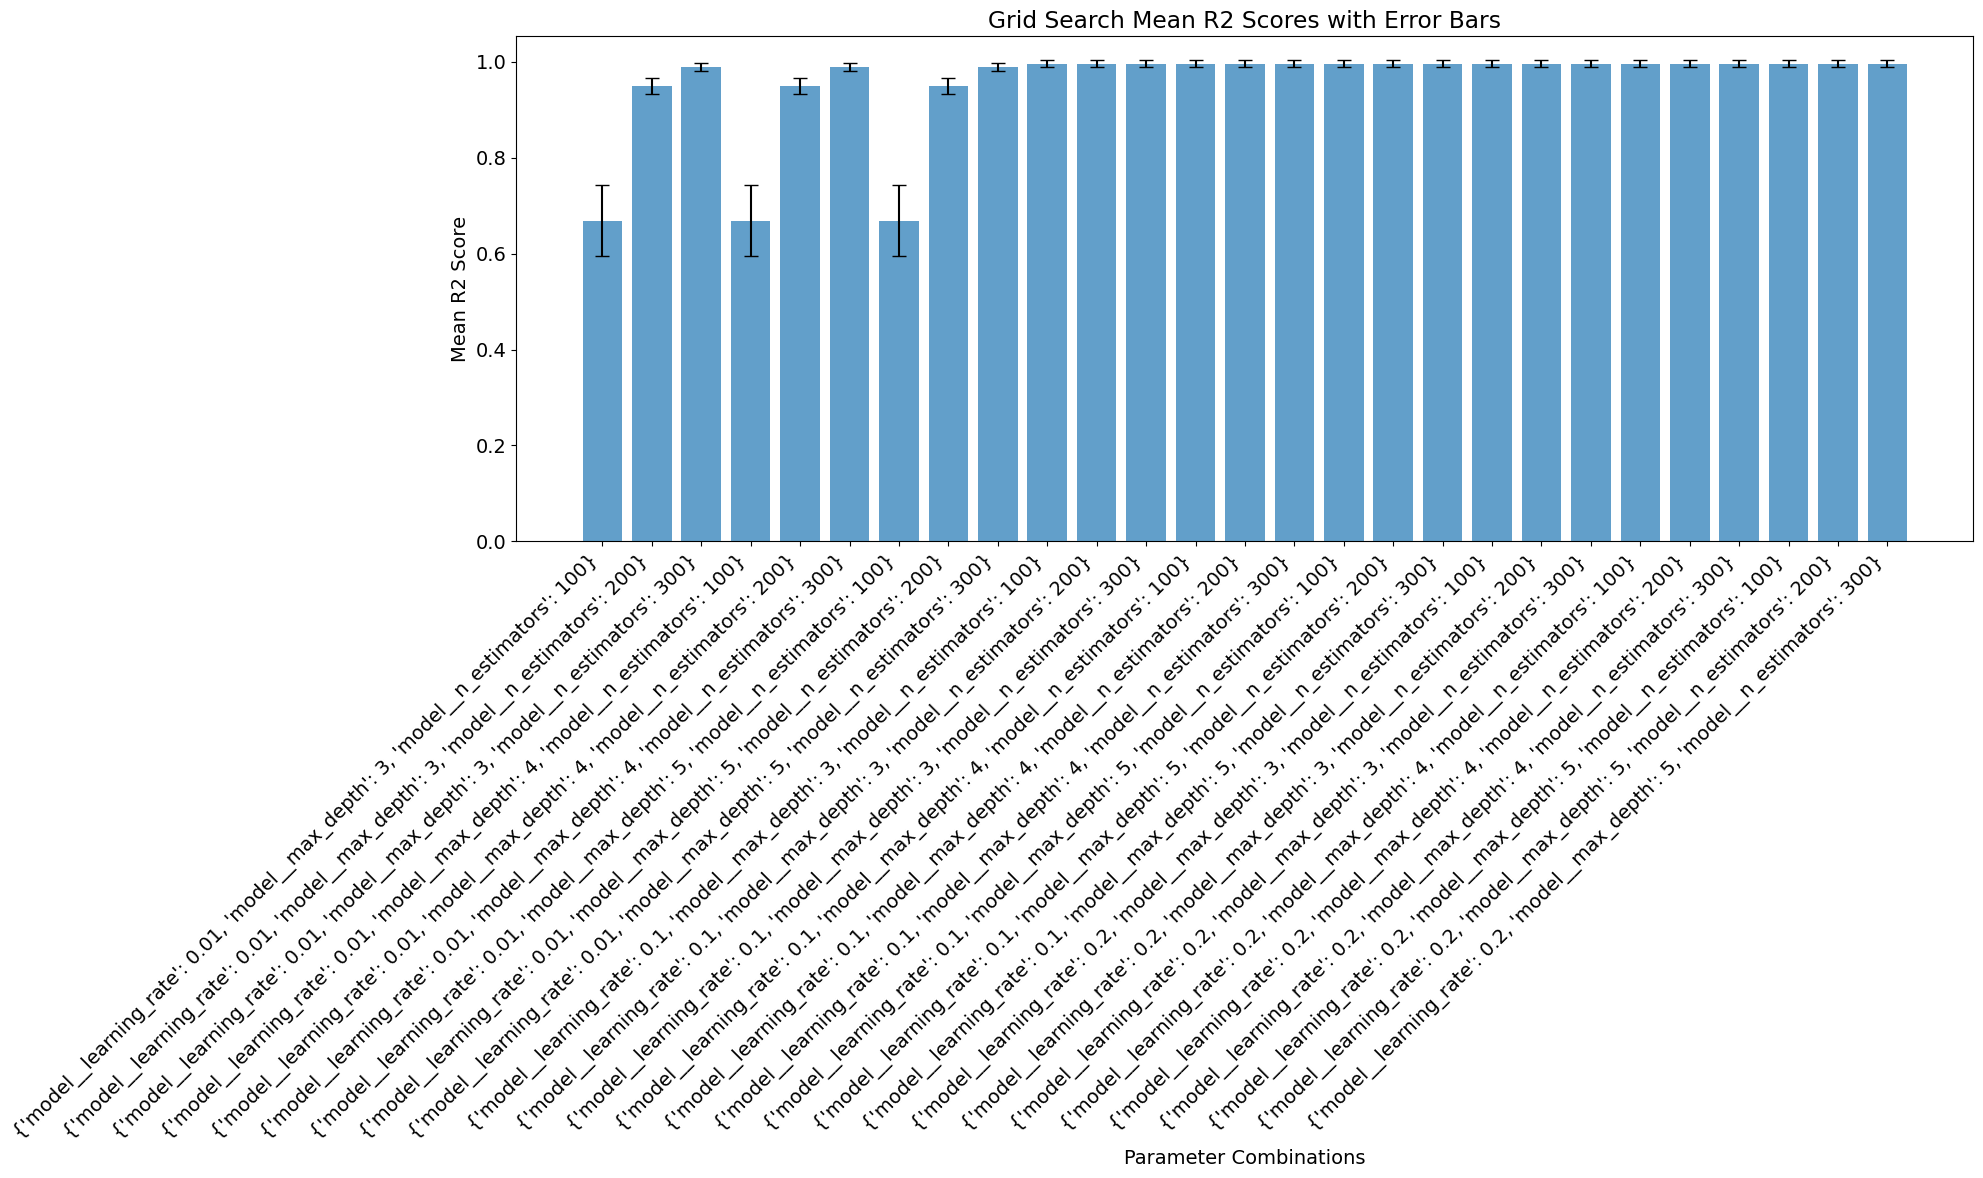

In [ ]:
# get the mean test scores and stdevs for each parameter combo
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = [str(param) for param in grid_search.cv_results_['params']]

# num of parameter combos
n_combinations = len(params)

# bar plot w mean test scores and error bars for std
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(20, 12))
x = np.arange(n_combinations)
plt.bar(x, mean_scores, yerr=std_scores, align='center', alpha=0.7, capsize=5)
plt.xticks(x, params, rotation=45, ha='right')
plt.xlabel('Parameter Combinations')
plt.ylabel('Mean R2 Score')
plt.title('Grid Search Mean R2 Scores with Error Bars')
plt.tight_layout()
plt.show()

### Compare Performance with the Dataset Where We're Not Withholding Plateau

In [ ]:
# define the groups for the full dataset
full_groups = tdf['polymer_name'].astype(str) + "_" + tdf['solvent_name'].astype(str)

# numeric features for the full dataset
full_numeric_features = tdf.select_dtypes(include=[np.number]).columns.tolist()

# cross-validation on full dataset using the best model (selected in code above)
cv_scores_full = cross_val_score(best_model, tdf[full_numeric_features], tdf['median_transmission'], groups=full_groups, cv=group_kfold.split(tdf[full_numeric_features], tdf['median_transmission'], groups=full_groups), scoring='r2', n_jobs=-1)

# compare performances
print("Performance on filtered plateau data:", np.mean(grid_search.cv_results_['mean_test_score']))
print("Performance on full dataset:", np.mean(cv_scores_full))

# create new group identifier for both dataframes
tdf['group_id'] = tdf['polymer_name'].astype(str) + "_" + tdf['solvent_name'].astype(str) + "_" + tdf['average_temperature'].astype(str)
filtered_data['group_id'] = filtered_data['polymer_name'].astype(str) + "_" + filtered_data['solvent_name'].astype(str) + "_" + filtered_data['average_temperature'].astype(str)

# get unique group identifiers from filtered_plateau_data
filtered_groups = filtered_data['group_id'].unique()

# split based on group identifier
train_data = tdf[~tdf['group_id'].isin(filtered_groups)]
test_data = tdf[tdf['group_id'].isin(filtered_groups)]

# train model on train_data
best_model.fit(train_data[full_numeric_features], train_data['median_transmission'])

# predict on the test data
test_predictions = best_model.predict(test_data[full_numeric_features])

# MAE and uncertainty (standard deviation)
mae = mean_absolute_error(test_data['median_transmission'], test_predictions)
uncertainty = np.std(test_predictions)

print("MAE on withheld plateau (test) data:", mae)
print("Uncertainty on withheld plateau (test) data:", uncertainty)

# k-fold cross-validation on the full dataset
kf_predictions = cross_val_predict(best_model, tdf[full_numeric_features], tdf['median_transmission'], cv=group_kfold.split(tdf[full_numeric_features], tdf['median_transmission'], groups=full_groups), groups=full_groups, n_jobs=-1)

# mean, stdev, and MAE
mean_pred = np.mean(kf_predictions)
std_pred = np.std(kf_predictions)
mae_pred = mean_absolute_error(tdf['median_transmission'], kf_predictions)

print("Mean of K-Fold predictions:", mean_pred)
print("Standard deviation of K-Fold predictions:", std_pred)
print("MAE of K-Fold predictions:", mae_pred)


Performance on filtered plateau data: 0.9539426544278117
Performance on full dataset: 0.9999962512676751


/var/folders/t6/ffy7gw3x49g_2s468zq_n_4r0000gn/T/ipykernel_32573/3912438825.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MAE on withheld plateau (test) data: 0.003398349891642419
Uncertainty on withheld plateau (test) data: 49.426167
Mean of K-Fold predictions: 65.18816
Standard deviation of K-Fold predictions: 43.420177
MAE of K-Fold predictions: 0.03416431714287296


# K-Fold Split (again)

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

additional_features = ['heating', 'cooling', 'holding']
features = ['conc', 'average_temperature'] + ffp_pols + ffp_sols + additional_features

kfold2_xgb_med = []

for pair in tqdm(unique_pairs, desc="Processing pairs"):
    target_polymer, target_solvent = pair
    df_pair = filtered_data.loc[(filtered_data['polymer_name'] == target_polymer) & (filtered_data['solvent_name'] == target_solvent)]
    unique_concs = df_pair['conc_round'].unique()

    for conc in unique_concs:
        test_data_conc = df_pair.loc[df_pair['conc_round'] == conc]
        train_data = filtered_data.loc[(filtered_data['polymer_name'] != target_polymer) | (filtered_data['solvent_name'] != target_solvent) | (filtered_data['conc_round'] != conc)]

        X_train = train_data[features].values
        y_train = train_data['median_transmission'].values

        all_predictions = []
        all_actuals = []

        for train_index, test_index in kf.split(X_train):
            model = xgb.XGBRegressor(min_child_weight=5, max_depth=10, subsample=0.8, colsample_bytree=0.8, n_estimators=300, learning_rate=0.1)  # tuned hyperparameters
            model.fit(X_train[train_index], y_train[train_index])

            pred = model.predict(X_train[test_index])
            all_predictions.extend(pred)
            all_actuals.extend(y_train[test_index])

        all_predictions = np.array(all_predictions)
        all_actuals = np.array(all_actuals)
        mae = mean_absolute_error(all_actuals, all_predictions)
        uncertainty = np.std(all_predictions)

        kfold2_xgb_med.append({'polymer': target_polymer,
                              'solvent': target_solvent,
                              'rounded_concentration': conc,
                              'true_concentration': test_data_conc['conc'].iloc[0],
                              'num_unique_concentrations': len(unique_concs),
                              'avg_temperature': test_data_conc['average_temperature'].iloc[0],
                              'predicted_med_transmission': np.mean(all_predictions),
                              'actual_med_transmission': np.mean(all_actuals),
                              'transmission_std': np.std(all_predictions),
                              'MAE': mae,
                              'Uncertainty': uncertainty})

Processing pairs: 100%|█████████████████████| 502/502 [1:57:24<00:00, 14.03s/it]


In [ ]:
kfold2_xgb_med_df = pd.DataFrame(kfold2_xgb_med)
kfold2_xgb_med_df.to_csv('kfold2_xgb_med_df.csv', index=False)

kfold2_xgb_med_df.head()

,polymer,solvent,rounded_concentration,true_concentration,num_unique_concentrations,avg_temperature,predicted_med_transmission,actual_med_transmission,transmission_std,MAE,Uncertainty
0,Cellulose acetate,1-octanol,15,14.98,1,12.0,65.171867,65.163783,27.740564,28.860174,27.740564
1,Cellulose acetate,Acetonitrile,15,14.96,1,10.0,65.083290,65.094794,27.755960,28.803764,27.755960
2,Cellulose acetate,Anisole,15,14.94,1,10.0,65.092636,65.094794,27.808409,28.739187,27.808409
3,Cellulose acetate,Benzene,15,14.91,1,10.0,65.103783,65.106488,27.760914,28.814061,27.760914
4,Cellulose acetate,Benzyl alcohol,15,15.04,1,10.0,65.086838,65.094947,27.829138,28.734211,27.829138


In [ ]:
kfold2_mean_uncertainty = kfold2_xgb_med_df['Uncertainty'].mean()
print(kfold2_mean_uncertainty)

analyze_metrics(kfold2_xgb_med_df)

27.727144
Overall Average Metrics:
MAE            28.762407
Uncertainty    27.727144
dtype: float64

Average Metrics by Rounded Concentration:
                             MAE  Uncertainty
rounded_concentration                        
5                      28.773708    27.736359
10                     28.802387    27.707264
15                     28.753520    27.729790
20                     28.817083    27.741232
30                     28.803045    27.703445
50                     28.761660    27.712910


# K-Fold Split (again) w Only Plateau Data

In [ ]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

additional_features = ['heating', 'cooling', 'holding']
features = ['conc', 'average_temperature'] + ffp_pols + ffp_sols + additional_features

plateau_kfold_xgb_med = []

for pair in tqdm(unique_pairs, desc="Processing pairs"):
    target_polymer, target_solvent = pair
    df_pair = filtered_plateau_data.loc[(filtered_plateau_data['polymer_name'] == target_polymer) & (filtered_plateau_data['solvent_name'] == target_solvent)]
    unique_concs = df_pair['conc_round'].unique()

    for conc in unique_concs:
        test_data_conc = df_pair.loc[df_pair['conc_round'] == conc]
        train_data = filtered_plateau_data.loc[(filtered_plateau_data['polymer_name'] != target_polymer) | (filtered_plateau_data['solvent_name'] != target_solvent) | (filtered_plateau_data['conc_round'] != conc)]

        X_train = train_data[features].values
        y_train = train_data['median_transmission'].values

        all_predictions = []
        all_actuals = []

        for train_index, test_index in kf.split(X_train):
            model = xgb.XGBRegressor(min_child_weight=5, max_depth=10, subsample=0.8, colsample_bytree=0.8, n_estimators=300, learning_rate=0.1)  # tuned hyperparameters
            model.fit(X_train[train_index], y_train[train_index])

            pred = model.predict(X_train[test_index])
            all_predictions.extend(pred)
            all_actuals.extend(y_train[test_index])

        all_predictions = np.array(all_predictions)
        all_actuals = np.array(all_actuals)
        mae = mean_absolute_error(all_actuals, all_predictions)
        uncertainty = np.std(all_predictions)

        plateau_kfold_xgb_med.append({'polymer': target_polymer,
                              'solvent': target_solvent,
                              'rounded_concentration': conc,
                              'true_concentration': test_data_conc['conc'].iloc[0],
                              'num_unique_concentrations': len(unique_concs),
                              'avg_temperature': test_data_conc['average_temperature'].iloc[0],
                              'predicted_med_transmission': np.mean(all_predictions),
                              'actual_med_transmission': np.mean(all_actuals),
                              'transmission_std': np.std(all_predictions),
                              'MAE': mae,
                              'Uncertainty': uncertainty})

Processing pairs: 100%|███████████████████████| 502/502 [01:46<00:00,  4.70it/s]


In [ ]:
plateau_kfold_xgb_med_df = pd.DataFrame(plateau_kfold_xgb_med)
plateau_kfold_xgb_med_df.to_csv('plateau_kfold_xgb_med_df.csv', index=False)

plateau_kfold_xgb_med_df.head()

,polymer,solvent,rounded_concentration,true_concentration,num_unique_concentrations,avg_temperature,predicted_med_transmission,actual_med_transmission,transmission_std,MAE,Uncertainty
0,Cellulose acetate,Acetonitrile,15,14.96,1,10.0,52.073582,55.776576,38.147209,46.869091,38.147209
1,Cellulose acetate,DMF,15,15.14,1,10.0,52.142807,55.776576,38.058945,46.894407,38.058945
2,Cellulose acetate,DMSO,15,14.92,1,12.0,52.095573,55.776576,37.753635,46.367944,37.753635
3,Cellulose acetate,Pyridine,15,15.36,1,10.0,51.800732,55.776576,37.827404,46.664461,37.827404
4,Dextran,DMSO,5,4.96,2,10.0,52.894642,56.348004,38.188049,45.811192,38.188049


In [ ]:
plateau_kfold_mean_uncertainty = plateau_kfold_xgb_med_df['Uncertainty'].mean()
print(plateau_kfold_mean_uncertainty)

analyze_metrics(plateau_kfold_xgb_med_df)

38.58758
Overall Average Metrics:
MAE            47.659983
Uncertainty    38.587582
dtype: float64

Average Metrics by Rounded Concentration:
                             MAE  Uncertainty
rounded_concentration                        
5                      47.399558    38.612350
15                     47.703897    38.561100
30                     48.284388    38.353905
50                     47.767547    38.721848


- fix so it's in-between data
- feature engineering
    - lasso regression/ridge
    - u-map
    - way to optimize the feature so cluster look really good (PP, PA, NPA, NPP)?
    - polar protic, polar a protic, non-...
    - a protic -> no hydrogen bond possible
    - take the features in the excel, use feature reduction like u-map to reduce number, then use that to model
    - see if we can map down our 119 features to 3 dimensions, and then use those as input features
- feature importance